In [1]:
###################################
# TODO: Figure out how to get ride of label encoding issues

In [2]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from collections import OrderedDict
from sklearn.preprocessing import LabelEncoder

In [64]:
#########################
# Deletes duplicates, one-hot encodes data
# Returns data (Pandas DF) and feature list (Dict)
#############################
def loadData(filename):
    data = pd.read_csv(filename).dropna()
    print("Choose Target column:")
    print(list(data))
    targetCol = input(">> ")
    while targetCol not in list(data):
        print(list(data))
        targetCol = input(">> ")
    targetOptions = data[targetCol].unique()
    
    le = -1
    if data[targetCol].dtype == object:
        le = LabelEncoder()
        le.fit(data[targetCol].unique())
        data[targetCol] = le.transform(data[targetCol])
    
    data = pd.get_dummies(data)
    return (data, targetCol, le)

In [65]:
################################
# Takes the test set, the targetCol, and the tree
# Computes the accuracy using sklearn's accuracy_score
# Returns the accuracy score
###############################
def getMetrics(myTree, myTests, targetCol):
    X = myTests.drop(targetCol, axis=1).copy()    
    y = myTests[targetCol]
    predictions = myTree.predict(X)
    accuracy =  accuracy_score(y, predictions)
    return accuracy

In [67]:
#####################
# Learn new Tree 
# Will interactively guide user to enter all required files
# Returns array containing the tree, list of attributes, and the target attribute
#####################
def LearnNewTree():
    dataPath = input("Enter name of data file: ")
    while dataPath != "" and dataPath[-4:] != ".csv": 
        isCSV = input("Is this a CSV?: ").lower()
        if isCSV.find("y") != -1: dataPath += ".csv"
        else: dataPath = input("Sorry, we need a .CSV file.\nEnter New File: ")

    try: 
        data, targetCol, le = loadData(dataPath)
        train_set, test_set = train_test_split(data, test_size = 0.2, random_state = 42)
    
        X = train_set.drop(targetCol, axis=1).copy()
        y = train_set[targetCol].copy()
            
    except Exception as e:
        print("Exception: " ,e)
        print('Sorry, data invalid. Is {} a valid csv datafile?'.format(dataPath))
        return -1

    try: 
        depth = input("Max Depth, or -1 to use none\n>> ")
        while not depth.isnumeric() and not depth[1:].isnumeric():
            depth = input("Max Depth, or -1 to use none\nPlease enter an integer\n>> ")
        if int(depth) > 0:
            myTree = DecisionTreeClassifier(max_depth = int(depth), random_state = 42)
        else:
            myTree = DecisionTreeClassifier(random_state = 42)

        myTree.fit(X, y)
        print("Tree Created")
        
        performance = getMetrics(myTree, test_set, y.name)
        print("Tree Accuracy Score: ", performance)
        
        if le == -1:
            return [myTree, list(X), (False, sorted(y.unique()))]
        return [myTree, list(X), (True, le)]
              
    except Exception as e:
        print("Exception: " ,e)
        print("Sorry, Tree build failed")
        return -1

In [68]:
#####################
# Pickles the array containing tree information
# Will interactively guide user to enter all required files
# Returns true if successful, o.w. print error and return false
#####################
def SaveTree(myTreeInfo):
    treeFile = ""
    while treeFile == "":
        treeFile = input("Tree File Name: ")
    try:
        pickle.dump(myTreeInfo, open(treeFile+".pickle", "wb"))
        return True
    
    except Exception as e:
        print("Oops, ", e)
        return false

In [69]:
#####################
# Unpickles the array containing the tree information
# Will interactively guide user to enter all required files
# Returns the tree, attributes, and target 
#####################
def LoadTree():
    try:
        treeFile = ""
        while treeFile == "":
            treeFile = input("Tree File Name: ")
        myTreeInfo = pickle.load(open(treeFile+".pickle", "rb"))
        return myTreeInfo
    
    except Exception as e: 
        print("LoadTree file {} is invalid".format(treeFile))
        return -1
    

In [78]:
########################
# Allows for one test case
# Takes the tree information
# Starts at first node in decision tree
# Asks if data is less than or greater than threshold
# Goes until reaches leaf node
# No Return
########################
def MakeDecision(myTreeInfo):
    
    myTree, myFeatures, encoding = myTreeInfo[0], myTreeInfo[1], myTreeInfo[2]
    nodeList=[]
    
    for node in range(0, myTree.tree_.node_count):
        prediction_values = myTree.tree_.value[node][0]

        largest = 0
        for i in range(0, len(prediction_values)):
            if prediction_values[i] > prediction_values[largest]:
                largest = i
        if encoding[0]: 
            prediction = encoding[1].inverse_encode([largest])[0]
        else:
            prediction = encoding[1][largest]
        nodeList.append((myFeatures[myTree.tree_.feature[node]], 
                         myTree.tree_.threshold[node],
                         myTree.tree_.children_left[node],
                         myTree.tree_.children_right[node],
                         prediction
                        ))
    current = 0
    while nodeList[current][2] > 0: #Not a leaf
        node = nodeList[current]
        print("{}: '<' (less than) or '>' (greater than): {}?".format(node[0],node[1]))
        operation = input(">> ")
        while operation not in [">","<"]:
            print("Must be > or <")
            operation = input(">> ")
        if operation == "<":
            current = node[2] #left
        else:
            current = node[3] #Right
        print(current)
        node = nodeList[current]
        print("Current Prediction is ", node[4])
    print("Final Prediction is ", node[4])

In [79]:
def main():
    try:
        myTreeInfo = -1 #empty Tree
        while(True):
            if myTreeInfo == -1:
                userIn = input("(1) to learn new decision tree\n"
                               "(4) to load previous decision tree\n"
                               "(5) to quit\n"
                               ">> "
                              )
            else: 
                userIn = input("(1) to learn new decision tree\n"
                               "(2) to save current tree\n"
                               "(3) to apply tree to new cases\n"
                               "(4) to load previous decision tree\n"
                               "(5) to quit\n"
                               ">> "
                              )
                
            if userIn.find("1") != -1:
                print("\nLearning New Tree\n")
                myTreeInfo = LearnNewTree()
            
            elif userIn.find("2") != -1:
                print("\nSaving Tree\n")
                SaveTree(myTreeInfo)
            
            elif userIn.find("3") != -1:
                print("\nApply Decision Tree\n")
                while(userIn.find("3") != -1):
                    MakeDecision(myTreeInfo)
                    userIn = input(  "(3) to continue decision-making\n"
                                     "(5) to quit\n"
                                     ">> "
                                  )
            
            elif userIn.find("4") != -1:
                print("\nLoading Tree\n")
                myTreeInfo = LoadTree()
            
            elif userIn.find("5") != -1:
                print("\nQuitting program...\n")
                break
            
            else:
                print("Sorry, command not recognized. Please try again.")
                continue
        print("Thank you for learning with our Decision Tree")
        print("Program exiting...")
    except Exception as e:
        print(e)
        print("Program terminating...")
        return(1)

In [ ]:
 if __name__== "__main__": 
        myTreePicture = main()

(1) to learn new decision tree
(4) to load previous decision tree
(5) to quit
>> 1

Learning New Tree

Enter name of data file: test.csv
Choose Target column:
['Day', 'Week', 'Price']
>> Price
Max Depth, or -1 to use none
>> 3
Tree Created
Tree Accuracy Score:  0.8888888888888888
(1) to learn new decision tree
(2) to save current tree
(3) to apply tree to new cases
(4) to load previous decision tree
(5) to quit
>> 3

Apply Decision Tree

Day_Tuesday: '<' (less than) or '>' (greater than): 0.5?
>> <
1
Current Prediction is  10
Week: '<' (less than) or '>' (greater than): 2.5?


In [72]:
myTreeInfo = LearnNewTree()
myTree, myFeatures, le = myTreeInfo[0], myTreeInfo[1], myTreeInfo[2]

Enter name of data file: test.csv
Choose Target column:
['Day', 'Week', 'Price']
>> Price
Max Depth, or -1 to use none
>> -1
Tree Created
Tree Accuracy Score:  1.0


In [73]:
myTreeInfo[2][1]

[2, 5, 10]

In [74]:
MakeDecision(myTreeInfo)

Day_Tuesday: '<' (less than) or '>' (greater than): 0.5?
>> <
1
Current Prediction is  [ 3.  0. 20.]
Week: '<' (less than) or '>' (greater than): 2.5?
>> <
2
Current Prediction is  [3. 0. 8.]
Week: '<' (less than) or '>' (greater than): 1.5?
>> <
3
Current Prediction is  [0. 0. 6.]
Final Prediction is  [0. 0. 6.]


In [76]:
myTree, myFeatures, le = myTreeInfo[0], myTreeInfo[1], myTreeInfo[4]
nodeList=[]
for node in range(0, myTree.tree_.node_count):
    prediction_values = myTree.tree_.value[node][0]
    largest = 0
    print(myTree.tree_.value[node][0])
    for i in range(0, len(prediction_values)):
        if prediction_values[i] < prediction_values[largest]:
            largest = i

    nodeList.append((myFeatures[myTree.tree_.feature[node]], 
                     myTree.tree_.threshold[node],
                     myTree.tree_.children_left[node],
                     myTree.tree_.children_right[node],
                     largest)
                    )

In [77]:
nodeList

[('Day_Tuesday', 0.5, 1, 8, array([ 3., 10., 20.])),
 ('Week', 2.5, 2, 7, array([ 3.,  0., 20.])),
 ('Week', 1.5, 3, 4, array([3., 0., 8.])),
 ('Day_Thursday', -2.0, -1, -1, array([0., 0., 6.])),
 ('Day_Thursday', 0.5, 5, 6, array([3., 0., 2.])),
 ('Day_Thursday', -2.0, -1, -1, array([0., 0., 2.])),
 ('Day_Thursday', -2.0, -1, -1, array([3., 0., 0.])),
 ('Day_Thursday', -2.0, -1, -1, array([ 0.,  0., 12.])),
 ('Day_Thursday', -2.0, -1, -1, array([ 0., 10.,  0.]))]

In [43]:
current = 0
while nodeList[current][2] > 0: #Not a leaf
    node = nodeList[current]
    print("{}: '<' (less than) or '>' (greater than): {}?".format(node[0],node[1]))
    operation = input(">> ")
    while operation not in [">","<"]:
        print("Must be > or <")
        operation = input(">> ")
    if operation == "<":
        current = node[2] #left
    else:
        current = node[3] #Right
    print(current)
    node = nodeList[current]
    print("Current Prediction is ", node[4])
print("Final Prediction is ", node[4])

IndexError: list index out of range

In [61]:
from sklearn.tree import export_graphviz
import graphviz

def showTree(myTreeInfo):
    export_graphviz(
        myTreeInfo[0],
        out_file="myTree",
        feature_names=myTreeInfo[1],
        class_names = ["2", "5", "10"],
        rounded=True,
        filled=True
    )
    from graphviz import render, Source
    return (Source.from_file('myTree'))

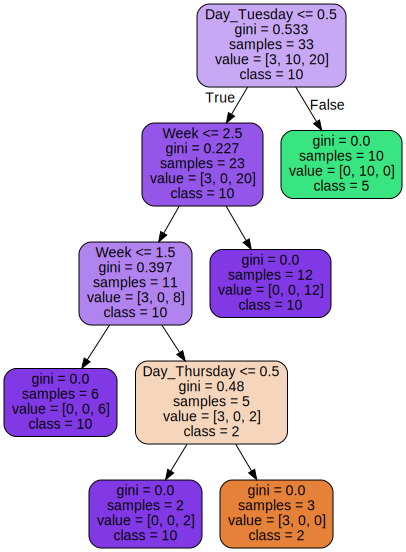

In [62]:
showTree(myTreeInfo)